# Imports

In [1]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig, pipeline
from PIL import Image
import pyaudio
import wave
import struct
from pvrecorder import PvRecorder
from pyannote.audio import Pipeline
from pydub import AudioSegment
import os
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torchaudio
import re
from ollama import chat
from ollama import ChatResponse
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\abhig\anaconda3\envs\dr_doc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\abhig\anaconda3\envs\dr_doc\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Functions

In [7]:
# Function to load the model and processor
def load_model_and_processor(model_name):
    """
    Loads the model and processor based on the provided model name.

    Args:
        model_name: The name of the model to load.

    Returns:
        model: The loaded language model.
        processor: The loaded processor.
    """
    processor = AutoProcessor.from_pretrained(
        model_name,
        trust_remote_code=True,
        torch_dtype='auto',
        device_map='auto'
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        trust_remote_code=True,
        torch_dtype='auto',
        device_map='auto'
    )

    return model, processor

# Function to process input and generate output
def generate_output(model, processor, image_path, input_text):
    """
    Processes the input image and text, and generates output using the model.

    Args:
        model: The loaded language model.
        processor: The loaded processor.
        image_path: Path to the input image.
        input_text: Text input for the model.

    Returns:
        generated_text: The text generated by the model.
    """
    # Open the image
    image = Image.open(image_path).convert("RGB")

    # Process the image and text
    inputs = processor.process(
        images=[image],
        text=input_text
    )

    # Move inputs to the correct device and make a batch of size 1
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # Generate output
    output = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=600, stop_strings=["<|endoftext|>"]),
        tokenizer=processor.tokenizer
    )

    # Decode the generated tokens to text
    generated_tokens = output[0, inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)


    return generated_text

def get_image_dimensions(image_path):
    # Open the image from the local path
    image = Image.open(image_path)
    # Get dimensions
    width, height = image.size
    return width, height

def record_audio_to_file(output_path, device_index=-1, frame_length=512, sample_rate=16000):
    """
    Records audio using PvRecorder and saves it to a WAV file.

    Args:
        output_path (str): Path to save the recorded audio.
        device_index (int): Index of the audio device (-1 for default device).
        frame_length (int): Frame length for recording.
        sample_rate (int): Sample rate of the audio (default 16000 Hz).
    """
    recorder = PvRecorder(device_index=device_index, frame_length=frame_length)
    audio = []

    try:
        print("Recording... Press Ctrl+C to stop.")
        recorder.start()

        while True:
            frame = recorder.read()
            audio.extend(frame)
    except KeyboardInterrupt:
        print("Recording stopped.")
        recorder.stop()
        with wave.open(output_path, 'w') as f:
            f.setparams((1, 2, sample_rate, 0, "NONE", "NONE"))
            f.writeframes(struct.pack("h" * len(audio), *audio))
        print(f"Audio saved to {output_path}")
    finally:
        recorder.delete()


def split_audio_by_speaker(audio_path, diarization, output_folder="Saved Audio/speakers"):
    """
    Splits an audio file into separate files for each speaker based on diarization results.

    Args:
        audio_path (str): Path to the original audio file.
        diarization: Diarization results from the Pyannote pipeline.
        output_folder (str): Directory to save the split audio files. Default is "Saved Audio/speakers".
    """
    # Load the original audio file
    audio = AudioSegment.from_wav(audio_path)

    # Create directories if they don't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize empty audio segments for each speaker
    speaker_segments = {}

    # Process each segment and add to corresponding speaker
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        start_ms = turn.start * 1000  # Convert to milliseconds
        end_ms = turn.end * 1000
        segment = audio[start_ms:end_ms]
        
        if speaker not in speaker_segments:
            speaker_segments[speaker] = AudioSegment.empty()
        
        speaker_segments[speaker] += segment

    # Export individual speaker audio files
    for speaker, audio_segment in speaker_segments.items():
        output_path = os.path.join(output_folder, f"{speaker.lower()}.wav")
        audio_segment.export(output_path, format="wav")
        print(f"Saved {speaker} audio to {output_path}")

def transcribe_audio(audio_path, model_name="openai/whisper-small"):
    """
    Transcribes an audio file using a Whisper model.

    Args:
        audio_path (str): Path to the audio file to transcribe.
        model_name (str): Name of the pre-trained Whisper model. Default is "openai/whisper-large-v2".

    Returns:
        str: Transcribed text from the audio.
    """
    # Load model and processor
    processor = WhisperProcessor.from_pretrained(model_name)
    model = WhisperForConditionalGeneration.from_pretrained(model_name)
    model.config.forced_decoder_ids = None

    # Load the audio file
    waveform, sampling_rate = torchaudio.load(audio_path)

    # Resample the audio if needed
    target_sampling_rate = processor.feature_extractor.sampling_rate
    if sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=target_sampling_rate)
        waveform = resampler(waveform)

    # Preprocess the audio
    input_features = processor(waveform.squeeze().numpy(), sampling_rate=target_sampling_rate, return_tensors="pt").input_features

    # Generate token IDs
    predicted_ids = model.generate(input_features)

    # Decode token IDs to text
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    return transcription[0]

def transcribe_long_audio(audio_path, model_name="openai/whisper-small", chunk_length_s=30):
    """
    Transcribes long audio files using a Whisper model with chunking.

    Args:
        audio_path (str): Path to the audio file to transcribe.
        model_name (str): Name of the pre-trained Whisper model. Default is "openai/whisper-small".
        chunk_length_s (int): Length of audio chunks in seconds. Default is 30 seconds.

    Returns:
        str: Complete transcribed text from the audio.
    """
    # Determine the device to use
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    # Load the pipeline for automatic speech recognition
    pipe = pipeline(
        "automatic-speech-recognition",
        model=model_name,
        chunk_length_s=chunk_length_s,
        device=device,
    )

    # Load the audio file
    waveform, sampling_rate = torchaudio.load(audio_path)

    # Resample the audio if needed
    target_sampling_rate = pipe.feature_extractor.sampling_rate
    if sampling_rate != target_sampling_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=target_sampling_rate)
        waveform = resampler(waveform)

    # Convert waveform to a dictionary format required by the pipeline
    audio_data = {
        "array": waveform.squeeze().numpy(),
        "sampling_rate": target_sampling_rate
    }

    # Transcribe the audio
    transcription = pipe(audio_data, batch_size=8)["text"]

    return transcription

def extract_items_after_hyphen(output):
    """
    Extracts and returns text after hyphens from a given multi-line string.

    Args:
        output (str): Multi-line string containing lines with hyphens.

    Returns:
        list: List of strings that appear after hyphens.
    """
    # Split lines and extract text after hyphens
    lines = output.splitlines()
    items_after_hyphen = [line.split('-', 1)[1].strip() for line in lines if '-' in line]
    return items_after_hyphen

def extract_fields_with_ollama(model_name, fields, transcriptions):
    """
    Use Ollama Llama3.2 to extract relevant fields from transcriptions.

    Args:
        model_name (str): The name of the Ollama model to use.
        fields (list): List of fields to fill.
        transcriptions (list): List of transcription strings.

    Returns:
        str: The response from the model containing extracted information.
    """
    # Combine fields and transcriptions into a single prompt
    fields_text = "\n".join(fields)
    transcriptions_text = "\n".join(transcriptions) if isinstance(transcriptions, list) else transcriptions
    prompt = (
        f"Extract the following fields from the provided transcriptions:\n"
        f"Fields:\n{fields_text}\n"
        f"Transcriptions:\n{transcriptions_text}\n"
        f"Output in a dictionary with field names as keys and extracted values as values. Do not add an extra demarkations of punctuations to make it print pretty."
    )
    # print('prompt:',prompt)
    # Send the request to the Ollama model
    response: ChatResponse = chat(model=model_name, messages=[
        {
            'role': 'user',
            'content': prompt,
        },
    ])

    # Return the response content
    # print('response:',response)
    return response['message']['content']

def extract_points(molmo_output, image_w, image_h):
    all_points = []
    for match in re.finditer(r'x\d*="\s*([0-9]+(?:\.[0-9]+)?)"\s+y\d*="\s*([0-9]+(?:\.[0-9]+)?)"', molmo_output):
        try:
            point = [float(match.group(i)) for i in range(1, 3)]
        except ValueError:
            pass
        else:
            point = np.array(point)
            if np.max(point) > 100:
                # Treat as an invalid output
                continue
            point /= 100.0
            point = point * np.array([image_w, image_h])
            all_points.append(point)
    return all_points

# Main

In [3]:
model_name = 'impactframes/molmo-7B-D-bnb-4bit'  # Replace with your model name
model, processor = load_model_and_processor(model_name)

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]


In [10]:
image_path = "Forms/health_assessment_form.png"  # Replace with your local image path
input_text = "list the 'empty' fields in the form in a new line list. No extra stuff."
output = generate_output(model, processor, image_path, input_text)
print("Generated Output:", output)

Generated Output:  Medical History
Current Medical Condition
Sleeping Patterns
Challenges with Sleeping
Exercise Frequency
Eating Habits Concerns
Smoking Status
Other Physical Health Information


In [5]:
output_file = "Saved Audio/asdf1.wav"
record_audio_to_file(output_file)

Recording... Press Ctrl+C to stop.
Recording stopped.
Audio saved to Saved Audio/asdf.wav


In [6]:
pipeline = Pipeline.from_pretrained(
        "pyannote/speaker-diarization-3.1",
        use_auth_token=""
    )
audio_path = "Saved Audio/asdf.wav"
diarization = pipeline(audio_path, num_speakers=2)

split_audio_by_speaker(audio_path, diarization)

INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
c:\Users\abhig\anaconda3\envs\dr_doc\lib\inspect.py:869: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):
c:\Users\abhig\anaconda3\envs\dr_doc\lib\site-packages\pyannote\audio\models\blocks\pooling.py:104: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  std = sequences.std(dim=-1, correct

Saved SPEAKER_01 audio to Saved Audio/speakers\speaker_01.wav
Saved SPEAKER_00 audio to Saved Audio/speakers\speaker_00.wav


In [7]:
audio_file_path = "Saved Audio\speakers\speaker_00.wav"  # Replace with the path to your audio file
transcription = transcribe_audio(audio_file_path)
print("Transcription:", transcription)

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription:  I don't have any major medical conditions. I usually get around six hours of sleep. I go to bed at 11 p.m. Wake up at 5 a.m. No


In [8]:
audio_file_path = "Saved Audio\speakers\speaker_01.wav"  # Replace with the path to your audio file
transcription = transcribe_audio(audio_file_path)
print("Transcription:", transcription)

Transcription:  Hi Jacob, let's go over some basic health details to better understand your overall health. First, could you tell me about any current medical conditions you might have? That's great to hear. Let's move on to your sleep. How many hours of sleep do you usually get each night? And what's your typical sleep schedule? 6 hours is a little less than the recommended amount. Have you noticed any challenges with your sleep? Like difficulty falling asleep or staying asleep? Not really, but sometimes I feel a bit tired during the day. Okay, thanks for sharing that. Moving on, how often do you exercise?


In [5]:
audio_file_path = "Saved Audio/asdf.wav"  # Replace with the path to your audio file
transcription = transcribe_long_audio(audio_file_path)
print("Transcription:", transcription)

Device set to use cuda:0
c:\Users\abhig\anaconda3\envs\dr_doc\lib\site-packages\transformers\models\whisper\generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpec

Transcription:  Hi Jacob, let's go over some basic health details to better understand your overall health. First, could you tell me about any current medical conditions you might have? Sure. I don't have any major medical conditions currently. That's great to hear. Let's move on to your sleep. How many hours of sleep do you usually get each night, and what's your typical sleep schedule? I usually get around six hours of sleep. I go to bed at 11 p.m. and wake up at 5 a.m. Six hours is a little less than the recommended amount. Have you noticed any challenges with your sleep? Like difficulty falling asleep or staying asleep? Not really, but sometimes I feel a bit tired during the day. Okay, thanks for sharing that. Moving on, how often do you exercise? I work out about three times a week. Mainly cardio and lightweight training. That's a solid routine. Any concerns with your eating habits, like irregular meals or specific cravings? No, I eat pretty regularly. Nothing out of the ordinary 

In [9]:
transcriptions = [transcribe_audio("Saved Audio\speakers\speaker_01.wav"), transcribe_audio("Saved Audio\speakers\speaker_00.wav")]
transcriptions

[' Hello I am Abhishek I am Dr. What are you going through? What are your symptoms?',
 ' Hi Dr. Abhishek, I have cough, cold and fever.']

In [11]:
model_name = "llama3.2:3b"
extracted_fields = extract_fields_with_ollama(model_name, output.split('\n'), transcription)
print("Extracted Fields:\n", extracted_fields)

Extracted Fields:
 {'Medical History': 'None', 
 'Current Medical Condition': 'None', 
 'Sleeping Patterns': '6 hours, 11 p.m. to 5 a.m.', 
 'Challenges with Sleeping': 'Sometimes feeling tired during the day', 
 'Exercise Frequency': 'Three times a week', 
 'Eating Habits Concerns': None, 
 'Smoking Status': 'Non-smoker', 
 'Other Physical Health Information': None}


# Experimentation

In [12]:
def annotate_form_with_values(image_path, extracted_fields, model, processor, output_path="annotated_form.png"):
    """
    Annotates a form image with values at specified points and saves it.

    Args:
        image_path (str): Path to the image of the form.
        extracted_fields (dict): Dictionary containing field names and their values.
        model: The model used for generating output points.
        processor: The processor used for preprocessing the form.
        output_path (str): Path to save the annotated image. Default is "annotated_form.png".

    Returns:
        None
    """
    w, h = get_image_dimensions(image_path)
    field_point_dict = {}
    img = cv2.imread(image_path)

    for key, value in eval(extracted_fields).items():
        input_text = f"point to the space in the form where '{key}' is can be filled in by someone filling the form."
        output_point = generate_output(model, processor, image_path, input_text)
        points = extract_points(output_point, w, h)
        field_point_dict[key] = points

        # Format the value for display
        if isinstance(value, str):
            text_value = value
        elif isinstance(value, (list, set)):
            text_value = "\n".join(map(str, value))
        elif isinstance(value, dict):
            text_value = "\n".join(f"{k}: {v}" for k, v in value.items())
        else:
            text_value = str(value)

        # Annotate the image with the value
        if points:  # Ensure points are not empty
            cv2.putText(img, text_value, (int(points[0][0]), int(points[0][1])), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

    # Save the annotated image
    cv2.imwrite(output_path, img)
    print(f"Annotated image saved to {output_path}")

image_path = "Forms/health_assessment_form.png"  # Replace with your local image path
output_path = "annotated_form.png"
annotate_form_with_values(image_path, extracted_fields, model, processor, output_path)

Annotated image saved to annotated_form.png


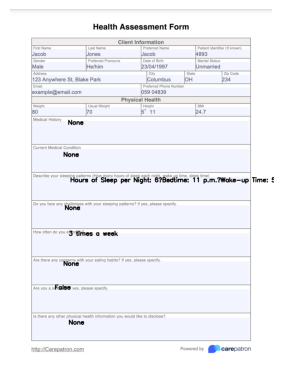

In [82]:
image_path = "Forms/health_assessment_form.png" 
w, h = get_image_dimensions(image_path)
field_point_dict = {}
img = cv2.imread(image_path)
for key, value in eval(extracted_fields).items():
    input_text = f"point to the space in the form where '{key}' is can be filled in by someone filling the form."
    output_point = generate_output(model, processor, image_path, input_text)
    points = extract_points(output_point, w, h)
    field_point_dict[key] = points
    # use open cv to write the value on the point in the image
    if isinstance(value, str):
        text_value = value
    elif isinstance(value, (list, set)):
        text_value = "\n".join(map(str, value))
    elif isinstance(value, dict):
        text_value = "\n".join(f"{k}: {v}" for k, v in value.items())
    else:
        text_value = str(value)

    cv2.putText(img, text_value, (int(points[0][0]), int(points[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

    

"{'Hours of Sleep per Night': 6, 'Bedtime': '11 p.m.', 'Wake-up Time': '5 a.m.'}"

In [75]:
image_path = "Forms/health_assessment_form.png"  # Replace with your local image path
input_text = "point to the space in the form where 'Are you a smoker? if yes please specify' is can be filled in by someone filling the form."
output_stage2 = generate_output(model, processor, image_path, input_text)
print("Generated Output:", output_stage2)

Generated Output:  <point x="20.7" y="76.8" alt="space in the form where 'Are you a smoker? if yes please specify' is can be filled in by someone filling the form.">space in the form where 'Are you a smoker? if yes please specify' is can be filled in by someone filling the form.</point>


In [76]:
w, h = get_image_dimensions(image_path)
points = extract_points(output_stage2, w, h)
print("Extracted Points:", points)

Extracted Points: [array([165.186, 860.16 ])]


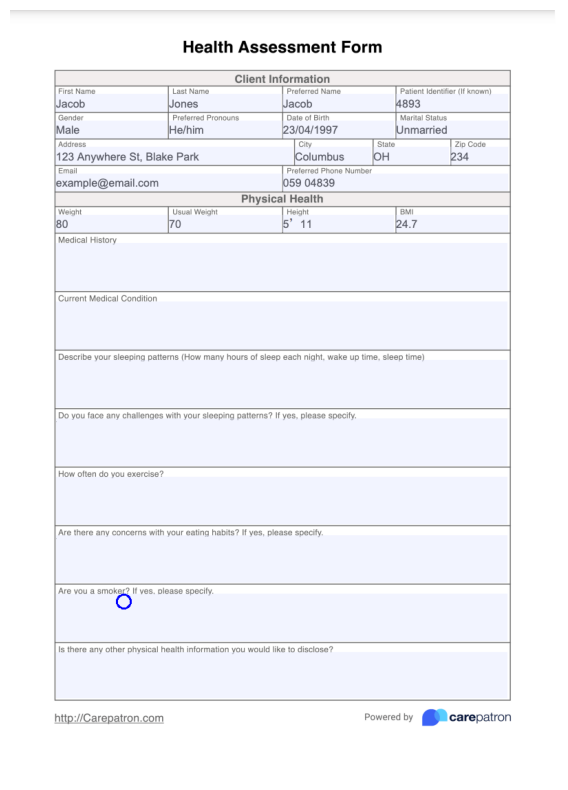

In [77]:
def draw_circle_on_image(image_path, points):
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    
    # Draw a blue circle at each point
    for point in points:
        x, y = int(point[0]), int(point[1])
        cv2.circle(image, (x, y), radius=10, color=(255, 0, 0), thickness=2)
    
    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.figure(figsize=(15, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Draw circles at the extracted points
draw_circle_on_image(image_path, points)
